
<h1> Data pipeline for UNDP Energy Moonshot Tracker </h1> 

This notebook executes the full data pipeline for ingesting the country-level energy project outputs alongside country metadata, data from the transparency portal API, donor information, and conversion factors based on our methodology to evaluate counts for direct and indirect beneficiaries. This data is then analyzed, visualized, and exported.

In [1]:
import pandas as pd
import os
import numpy as np
import warnings
import random
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import json
from tqdm import tqdm
import ast
import countrynames
import math
from urllib.request import urlopen
import re
import xlsxwriter
from functools import reduce
import openai
import os
from dotenv import load_dotenv
import hashlib
from urllib.parse import urlparse
import numbers


<h2> Prepare data (Projects, Outputs, Donors, and Countries) </h2>

<h4> Country metadata and tracker </h4>

In [2]:

#country metadata
countryMetadata=pd.read_csv("../01_Input/03_Country Meta/countryMetadataInput.csv")

#print(countryMetadata)

countryMetadata.to_csv("../02_Output/03_Countries/countryMetadata.csv")

print(countryMetadata["Country Name"].tolist())

['Afghanistan', 'Åland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil', 'British Indian Ocean Territory', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon, Republic of', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia', 'Comoros', 'Congo', 'Dem. Rep. of the Congo', 'Cook Islands', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',

<h4> Create dataframes for projects and outputs </h4>

In [3]:
df=pd.read_excel("../01_Input/00_CO Validation/Togo - Energy Projects.xlsx", sheet_name="Projects (3)")


In [4]:
##analyze projects included

countryList=[]

projectDict={}
outputDict={}

file_path="../01_Input/00_CO Validation/"

def countryNameToCode(countryName):         
    try:
        countryCode=countryMetadata.loc[countryMetadata['Country Name'] == countryName, 'Country Code'].values[0]
        if countryCode not in countryList:
            countryList.append(countryCode)
    except:
        countryCode="NA"
        print(f"Missing country metadata for: {countryName}")   
    return countryCode

for root, directories, files in os.walk(file_path):
    count=0
    for name in files:
        if "$" not in name and "DS" not in name and "Energy Projects" in name:            
            try:
                df=pd.read_excel(file_path+name, sheet_name="Projects (3)")
            except:
                print(name + " can't read projects(3) df")
                
            countryName=name.split(" -")[0]
            countryCode=countryNameToCode(countryName)
            
            
            projectId="none"
            
            for index,row in df.iterrows():
                
                if "Country" in row:
                    if not pd.isna(row["Country"]):
                        print(row["Country"])
                        countryName=row["Country"]      
                        countryCode=countryNameToCode(countryName)

                #if there is something in the id column, set the current project info
                if str(row["Project ID"])!="nan" and len(str(row["Project ID"]).strip())>0:
                    projectId=row["Project ID"]
                    #check if id works (need to update this to handle multi-ids)
                    if str(projectId).replace('.','').strip().isnumeric() or "missing" in str(projectId):
                        #print(projectId)
                        pass
                    
                    budget=0
                    if "Budget" in row:
                        budget=row["Budget"]
                    elif "Budget (USD)" in row:
                        budget=row["Budget (USD)"]
                    if "$" in str(budget):
                        budget=budget.split("$")[-1]
                    try:
                        budget=float(budget)
                    except:
                        #print(budget,countryName)
                        budget=-1##just a flag that the budget is tbd
                    try:
                        vf=row["VF or Non-VF"]
                    except:
                        ###this is temp
                        if len(str(projectId))<6:
                            vf="VF"
                        else:
                            vf="Non-VF"
                    title=row["Title"]
                    link=row["Link"]
                    try:
                        donors=row["Donors"]
                    except:
                        donors=""

                    try:
                        projectDescription=row["Project Description"]
                    except:
                        projectDescription=""
                    
                if projectId!="none":
                    
                    count+=1

                    if str(projectId) not in projectDict:
                        projectDict[str(projectId)]={"Project ID":projectId,
                                                "Project Title":title,
                                                "Budget":budget,
                                                "Country":countryName,
                                                "Country Code":countryCode,
                                                "Link":link,
                                                "Donors":donors,
                                                "VF or Non-VF":vf,
                                                "Output Count":1,
                                                "Project Description":projectDescription}
                        newOutputId=str(projectId)+"-1"
                    else:
                        projectDict[str(projectId)]["Output Count"]+=1
                        newOutputId=str(projectId)+"-"+str(projectDict[str(projectId)]["Output Count"])

                    newOutput=row
                    newOutput["Beneficiary Category"]=str(newOutput["Beneficiary Category"]).strip()
                    projectMeta=projectDict[str(projectId)]
                    newOutput["Output ID"]=newOutputId
                    newOutput["Project ID"]=projectMeta["Project ID"]
                    newOutput["Title"]=projectMeta["Project Title"]
                    newOutput["Country Code"]=countryCode
                    newOutput["Country"]=projectMeta["Country"]
                    newOutput["Link"]=projectMeta["Link"]
                    newOutput["Budget"]=projectMeta["Budget"]
                    newOutput["VF or Non-VF"]=projectMeta["VF or Non-VF"]
                    newOutput["Project Description"]=projectMeta["Project Description"]


                    outputDict[newOutputId]=newOutput
                else:
                    print(countryCode," - ",projectId," - ", title," - bad ID")
                            

projectDf=pd.DataFrame.from_records([*projectDict.values()])
outputDf=pd.DataFrame.from_records([*outputDict.values()])




projectDf.to_csv("../02_Output/01_Projects/projectDfValidation.csv")
outputDf.to_csv("../02_Output/02_Outputs/outputDfValidation.csv")
print(count)

Samoa
Samoa
Niue
Missing country metadata for: Nature Hub
Missing country metadata for: Bureau Policy & Prog Support
Barbados
Fiji (+10 member countries of Pacific Island Development Forum)
Missing country metadata for: Fiji (+10 member countries of Pacific Island Development Forum)
Vanuatu
Tuvalu
Nauru
Kiribati
Federated States of Micronesia
Vanuatu
Mauritius
Mauritius
Mauritius
Missing country metadata for: New York
1187


In [5]:
#calculate project and output stats
projectList=projectDf["Project ID"].tolist()
print(len(projectList), "projects")
print(len(outputDict), "outputs")
print(projectDf["Budget"].sum(),"budget")

398 projects
1187 outputs
4228226005.4849195 budget


<h2> Process dataframes (Projects, Outputs, Donors, and Countries) </h2>

<h4> Clean up outputDf </h4>

In [6]:
#keep only certain headers (need to clean data to correct names)

headers=["Project ID","Project Description","Output ID","Country Code","Title","Link","Budget","Beneficiary Category","Indicator","Baseline","Target","Notes","Donors","Gender (% female)","Flagship","Tag","SEH Taxonomy","RISE Taxonomy","Technology","Category","Policy-taxonomy","VF or Non-VF"]      

outputDf=outputDf[outputDf.columns[outputDf.columns.isin(headers)]]


In [7]:
#add country metadata (region and other groupings), country code, to outputDf
outputDfComplete=pd.merge(outputDf,countryMetadata,on="Country Code",how='left')
outputDfComplete.columns.values

array(['Project ID', 'Title', 'Link', 'Budget', 'Beneficiary Category',
       'Indicator', 'Baseline', 'Target', 'Notes', 'Donors',
       'Gender (% female)', 'VF or Non-VF', 'Tag', 'SEH Taxonomy',
       'RISE Taxonomy', 'Flagship', 'Technology', 'Output ID',
       'Country Code', 'Project Description', 'Category', 'Country Name',
       'm49', 'continent-region', 'sub-region', 'sids-region',
       'un-member', 'undp-sids', 'un-region', 'Region', 'Economy', 'LDC',
       'SIDS', 'LLDC', 'HDI', 'Sahel', 'Crisis'], dtype=object)

In [8]:
#donors for outputs could be updated to include atlas and pims data

<h2> Beneficiaries Conversion </h2>

<h4> direct conversion </h4>

In [9]:
#load Direct conversion Scores
directConversion=pd.read_csv("../01_Input/01_Methodology/Direct Conversion Factors.csv")
#HH data
HHdata=pd.read_csv("../01_Input/03_Country Meta/HHData.csv")
print(HHdata)



     Country or area Average household size (number of members)  \
0           Zimbabwe                                       4.02   
1           Zimbabwe                                       4.08   
2           Zimbabwe                                       4.16   
3           Zimbabwe                                       4.04   
4           Zimbabwe                                       4.15   
...              ...                                        ...   
1053         Albania                                       3.82   
1054         Albania                                          4   
1055         Albania                                       4.35   
1056     Afghanistan                                       8.04   
1057     Afghanistan                                       7.75   

     Data source category Reference date (dd/mm/yyyy)  
0                    MICS                      1/7/19  
1                     DHS                  27/09/2015  
2                    MICS  

In [10]:
#add column for direct beneficiaries convert
  
def getDirectFactor(category):
    try:
        return directConversion.loc[directConversion["Beneficiary Category"]==category,"Factor"].values[0]
    except:
        return 0
    
def convertHH(row):
    target=str(row["Target"]).replace(',', '')
    if "HH" in target:
        try:
            householdSize=HHdata[HHdata["Country or area"]==row["Country Name"]].iloc[0]["Average household size (number of members)"]
        except:
            householdSize=5
            print("no HH for", row["Country Name"])
        try:
            return int(target.split("HH")[0])*float(householdSize)
        except:
            print(target,"contains HH but broken")
            return target
    else:
        try: 
            return float(target)
        except:
            print(target,row["Country Name"],"incorrect format") ##this will show all nonnumeric targets
            return target
    
outputDfComplete["Direct Conversion Factor"]=outputDfComplete["Beneficiary Category"].apply(lambda x: getDirectFactor(x))
   
outputDfComplete['Target'] =  outputDfComplete.apply(convertHH, axis=1)

outputDfComplete["Direct Beneficiaries"]=(pd.to_numeric(outputDfComplete['Target'], errors='coerce').fillna(0)-pd.to_numeric(outputDfComplete['Baseline'], errors='coerce').fillna(0))*outputDfComplete["Direct Conversion Factor"]
outputDfComplete["Direct Beneficiaries"] = pd.to_numeric(outputDfComplete["Direct Beneficiaries"], errors='coerce')



132 target Samoa incorrect format
no HH for Niue
1 new energy mix  Algeria incorrect format
358 363 Comoros incorrect format
no HH for Moldova Republic
no HH for Moldova Republic
no HH for Moldova Republic
1. 2 drafts/amendments for the energy policy documents are developed consulted and presented to relevant authorities for further approval; 

2. at least 10 draft regulatory documents developed consulted and presented for relevant authorities for approval   Moldova Republic incorrect format
no HH for Moldova Republic
4.1.2. Target: 7


4.2.1.  Target: 215000 (Women: 64500/Men: 150500)

4.2.4. Target: 34

4.3.3.Target: 130 Moldova Republic incorrect format
3000000 consumers outreach (40% women)
60000 consumers (households )
4
1
3000000 people (40% women)
50 journalists system operators institutions and civil society representatives
60000 households prosumers and public sector entities
1500 households/apartments in MAB
1 established unified RNLC
 Moldova Republic incorrect format
70% of

In [11]:
outputDfComplete


,Project ID,Title,Link,Budget,Beneficiary Category,Indicator,Baseline,Target,Notes,Donors,...,Region,Economy,LDC,SIDS,LLDC,HDI,Sahel,Crisis,Direct Conversion Factor,Direct Beneficiaries
0,117913.0,Résilience des communautés et des écosystèmes,http://open.undp.org/projects/00117913,3459600.0,Electricity Access,Nombre de ménages ayant accès à l’énergie sola...,0,3697.5,"Nombre de ménages dirigés par les hommes: 650,...",UNDP,...,RBA,Low income,LDC,NaN,NaN,Low,NaN,NaN,1,3697.5
1,117913.0,Résilience des communautés et des écosystèmes,http://open.undp.org/projects/00117913,3459600.0,nan,Pourcentage des producteurs de charbon dans le...,0,460.0,Il ya 576 productrices de chanbons qui ont été...,UNDP,...,RBA,Low income,LDC,NaN,NaN,Low,NaN,NaN,0,0.0
2,117913.0,Résilience des communautés et des écosystèmes,http://open.undp.org/projects/00117913,3459600.0,nan,Pourcentatge des femmes productrices de charbo...,0,460.0,Il ya 576 productrices de chanbons qui ont été...,UNDP,...,RBA,Low income,LDC,NaN,NaN,Low,NaN,NaN,0,0.0
3,134793.0,Accès aux énergies renouvelables en milieu rur...,http://open.undp.org/projects/00134793,1431552.0,Electricity Access,"Nombre de ménages dans les villages ciblés, y ...",0,6525.0,Nombre de ménages dirigés par les hommes: 1200...,UNDP,...,RBA,Low income,LDC,NaN,NaN,Low,NaN,NaN,1,6525.0
4,134793.0,Accès aux énergies renouvelables en milieu rur...,http://open.undp.org/projects/00134793,1431552.0,nan,Nombre de personnes bénéficiant des services d...,10000,50000.0,Environ 50 000 personnes au Total,UNDP,...,RBA,Low income,LDC,NaN,NaN,Low,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,130610,Multilateral Support to COP27,Qunatum,1500000.0,Energy (MW added),Electricity generation capacity shfited from f...,0,1.5,The added PV capacities will be mainly impleme...,EU,...,RBAS,Lower middle income,NaN,NaN,NaN,High,NaN,NaN,17500,26250.0
1183,132255.0,Projet d’Electrification Rurale en Zones Isol...,NaN,329490000.0,Electricity Access,"1. Percentage of populations, disaggregated by...",0.0,300000.0,The objective of PERZI is to create the condit...,"Gouvernment, UNDP,",...,RBA,Lower middle income,LDC,NaN,NaN,Medium,Sahel,NaN,1,300000.0
1184,132255.0,Projet d’Electrification Rurale en Zones Isol...,NaN,329490000.0,Capacity Building Training,Number of people who benefits from training fo...,NaN,1000.0,NaN,"Gouvernment, UNDP,",...,RBA,Lower middle income,LDC,NaN,NaN,Medium,Sahel,NaN,0,0.0
1185,132255.0,Projet d’Electrification Rurale en Zones Isol...,NaN,329490000.0,nan,NaN,NaN,200.0,NaN,"Gouvernment, UNDP,",...,RBA,Lower middle income,LDC,NaN,NaN,Medium,Sahel,NaN,0,0.0


<h4> indirect conversion </h4>

In [12]:
#open electricity access % data
eAccessDf=pd.read_csv("../01_Input/02_Energy Data/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_5358776/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_5358776.csv")
popDf=pd.read_csv("../01_Input/02_Energy Data/API_SP.POP.TOTL_DS2_en_csv_v2_5436324/API_SP.POP.TOTL_DS2_en_csv_v2_5436324.csv")
renewableDf=pd.read_csv("../01_Input/02_Energy Data/API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_5359592/API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_5359592.csv")
cleanDf=pd.read_csv("../01_Input/02_Energy Data/API_EG.CFT.ACCS.ZS_DS2_en_csv_v2_5362815/API_EG.CFT.ACCS.ZS_DS2_en_csv_v2_5362815.csv")

renewableDf=renewableDf.set_index("Country Code")
cleanDf=cleanDf.set_index("Country Code")
eAccessDf=eAccessDf.set_index("Country Code")
popDf=popDf.set_index("Country Code")

In [13]:
dfList=[]
proportionDict={}
for country in eAccessDf.index:
    
    elAccessPercent=(100-eAccessDf.loc[country]["2020"])/100
    cleanPercent=cleanDf.loc[country]["2020"]/100
    effiPercent=eAccessDf.loc[country]["2020"]/100
    renewPercent=renewableDf.loc[country]["2019"]/100
    
    countryPop=popDf.loc[country]["2020"]
    
    elAccess=elAccessPercent*countryPop
    clean=cleanPercent*countryPop
    effi=effiPercent*countryPop
    renew=renewPercent*countryPop
    
    count=0
    total=0
    
    for val in [elAccess,clean,effi,renew]:
        if not pd.isna(val):
            count+=1
            total+=val
    
    if count>0:
        overall=total/count
    else:
        overall=0
        
    proportionDict[country]={"Electricity access":elAccessPercent,"Clean cooking":cleanPercent,"Energy efficiency":effiPercent,"Renewable energy":renewPercent,"Overall":overall/countryPop}
    dfList.append({"Country Code":country,"Electricity access":elAccess,"Clean cooking":clean,"Energy efficiency":effi,"Renewable energy":renew,"Overall":overall})

indirectPotentials=pd.DataFrame.from_records(dfList)

indirectPotentials.to_csv("../02_Output/03_Countries/indirectPotential.csv")

In [14]:
# #load Indirect conversion scores
# indirectConversion=pd.read_csv("../01_Input/01_Methodology/Indirect Conversion Factors.csv")
# #load RISE scores
# riseScores=pd.read_excel("../01_Input/02_Energy Data/RISE Scores-2.xlsx")

# def getIndirectBeneficiaries(row):
#     if row["Beneficiary Category"]=="Policy or Regulatory Framework":
#         try:
#             category=row["RISE Taxonomy"]
#         except:###DELETE
#             category="Overall"
        
#         proportion=proportionDict[row["Country Code"]][category]
#         if "Scope" not in row.keys().tolist():#####DELETE
#             row["Scope"]="National"
        
#         if row["Scope"]=="National":
#             potentialPopulation=popDf.loc[row["Country Code"]]["2020"]
#         else:
#             potentialPopulation=row["Policy Population"]
        
#         return potentialPopulation*proportion
        
#     else:
#         return 0
    
# outputDfComplete["Indirect Beneficiaries"]=outputDfComplete.apply(lambda row: getIndirectBeneficiaries(row),axis=1)

# outputDfComplete["Indirect Beneficiaries"] = pd.to_numeric(outputDfComplete["Indirect Beneficiaries"], errors='coerce')

# print(outputDfComplete[outputDfComplete["Beneficiary Category"]=="Policy or Regulatory Framework"])


In [15]:
##add direct and indirect beneficiaries count to projectDf

projectDf["Direct Beneficiaries"]=projectDf["Project ID"].apply(lambda x: outputDfComplete[outputDfComplete["Project ID"]==x]["Direct Beneficiaries"].sum())

ghgDfComplete=outputDfComplete[outputDfComplete["Beneficiary Category"]=="GHG Emissions Reduction"]

def sumGhg(ghgList,project_id):
    
    ghg=0.0
    for i in ghgList:
        try:
            ghg+=float(i)
        except:
            print(project_id," ghg broken")
    return ghg
    

projectDf["GHG Emissions Reduction"]=projectDf["Project ID"].apply(lambda x: sumGhg(ghgDfComplete[ghgDfComplete["Project ID"]==x]["Target"].tolist(),x))



# projectDf["Indirect Beneficiaries"]=projectDf["Project ID"].apply(lambda x: outputDfComplete[outputDfComplete["Project ID"]==x]["Indirect Beneficiaries"].sum())


93964.0  ghg broken
127444.0  ghg broken
117898  ghg broken
116395  ghg broken
00110796(AC Unit) & 00117012 (PMU)  ghg broken


<h4> Add energy efficiency (and GHG emissions reduction?) </h4>

In [16]:
# outputDfComplete["GHG Emissions Reduction"]=outputDfComplete.apply(lambda row: (row["Beneficiary Category"]=="GHG Emissions Reduction")*row["Target"],axis=1)
# # #Energy Saved (MJ)

#####to projects instead now??

In [17]:
productiveUseCategories=[
    "Agriculture and Food System",
    "Health Services",
    "Education Services",
    "Transportation and E-mobility Services",
    "Water Services",
    "Energy Infrastructure Services",
    "Other Energy Services"
]

In [18]:

#community centers
#displacement settings

def getBeniCategory(row):
    if row["Beneficiary Category"] in productiveUseCategories+["Electricity Access","Clean Cooking"]:
        outputCategory="Energy Access"
    elif row["Beneficiary Category"] in ["Energy (MW added)","Energy Efficiency Services"]:
        outputCategory="Energy Transition"
    elif row["Beneficiary Category"]=="Policy or Regulatory Framework":
        outputCategory="Policy"
    elif row["Beneficiary Category"]=="GHG Emissions Reduction":
        outputCategory="GHG Emissions Reduction"
    else:
        outputCategory="Other"
    return outputCategory
        
outputDfComplete["Output Category"]=outputDfComplete.apply(lambda row: getBeniCategory(row),axis=1)


In [19]:
def getBeniSubcategory(row):
    
    if row["Output Category"]=="Energy Transition":
        if row["Beneficiary Category"]=="Energy Efficiency Services":
            beneficiaryCategory="Efficiency"
        elif type(row["Technology"])==str: 
            beneficiaryCategory=row["Technology"]
        else:
            beneficiaryCategory="Transition Missing"    
    elif row["Beneficiary Category"] in productiveUseCategories:
        beneficiaryCategory=row["Beneficiary Category"]##this changes nothing
        
    elif row["Beneficiary Category"] in ["Electricity Access","Energy (MW added)"]:
        beneficiaryCategory="Clean Electricity"
    
    elif row["Beneficiary Category"] =="Clean Cooking":
        beneficiaryCategory="Clean Cooking"

    elif row["Beneficiary Category"]=="Policy or Regulatory Framework":
        try:
            beneficiaryCategory="Policy - "+row["RISE Taxonomy"]
        except:
            beneficiaryCategory="Policy - Other"
        
    else:##need to add finance here
        beneficiaryCategory="Other"
        print(row["Beneficiary Category"])
    return beneficiaryCategory     

        
outputDfComplete["Beneficiary Category Pre"]=outputDfComplete["Beneficiary Category"]
outputDfComplete["Beneficiary Category"]=outputDfComplete.apply(lambda row: getBeniSubcategory(row),axis=1)

nan
nan
nan
Medium Enterprises
GHG Emissions Reduction
nan
GHG Emissions Reduction
nan
GHG Emissions Reduction
GHG Emissions Reduction
Capacity Building Training
Capacity Building Training
nan
Small Enterprises
Capacity Building Training
nan
Capacity Building Training
nan
Capacity Building Training
Capacity Building Training
Other
Entrepreneurship Training
Entrepreneurship Training
Capacity Building Training
GHG Emissions Reduction
Market Intervention
Capacity Building Training
Small Enterprises
Capacity Building Training
Entrepreneurship Training
Entrepreneurship Training
Capacity Building Training
GHG Emissions Reduction
nan
nan
nan
Capacity Building Training
GHG Emissions Reduction
GHG Emissions Reduction
nan
nan
nan
nan
nan
Campaign Participant
Capacity Building Training
Campaign Participant
Medium Enterprises
Medium Enterprises
nan
GHG Emissions Reduction
nan
Capacity Building Training
Capacity Building Training
Capacity Building Training
Medium Enterprises
Entrepreneurship Traini

<h1> Update outputs, projects, donors, and country data with api, pims, and summary stats </h1>

<h3>download portfolio data from API</h3>

In [20]:
#should refactor this so there is a single retreival of country metadata
allCountryCodes=pd.read_csv("../01_Input/03_Country Meta/country-iso.csv")["alpha-3"].unique().tolist()
unregions=pd.read_csv("../02_Output/03_Countries/countryMetadata.csv").set_index("Country Code")
bureaus=pd.read_csv("../01_Input/03_Country Meta/country-iso.csv").set_index("alpha-3")

In [21]:
def nameToIsoGlobal(countryName):
    iso=countrynames.to_code_3(countryName, fuzzy=True)
    if iso==None:
        iso="NA"
    return iso

In [22]:
solutionsDict={"Others":7,
"Enhance national prevention and recovery capacities for resilient societies":3,
"Promote nature-based solutions for a sustainable planet":4,
"Keeping people out of poverty":1,
"Close the energy gap":5,
"Strengthen gender equality and the empowerment of women and girls":6,
"Strenghten gender equality and the empowerment of women and girls":6,
              "Strengthen effective, inclusive and accountable governance":2}

In [23]:
#test
# j = pd.read_json('https://api.open.undp.org/api/project_list/?year={}&operating_unit={}'.format("2022","TUV"))
# for d in j.data.data:
#     print(d)

In [24]:

def downloadFullPortfolio():

    #fundingCategories=pd.read_csv("../../SIDS-Data-Platform-API/api/data/portfolio/fundingCategories.csv",encoding="utf-8")
    #fundingCategories=fundingCategories.set_index('donor')

    df = pd.DataFrame()

    rows=[]


    for country in allCountryCodes:
        print(country)
        for yr in range(2010,2023):
            j = pd.read_json('https://api.open.undp.org/api/project_list/?year={}&operating_unit={}'.format(yr,country))
            for d in j.data.data:
                #print(d)
                try:
                    sdg = [int(s['id']) for s in d['sdg']]
                except:
                    sdg = None
                try:
                    solution = [s['name'] for s in d['signature_solution']]
                except:
                    solution = None

                title=d['title']

                donors= d['donor']
                
                unregion=unregions.loc["AFG"]["un-region"]
                bureau=bureaus.loc["AFG"]["undp-region"]

                line = {'Project ID':d['project_id'],
                        'country_atlas':country,
                        'un-region':unregion,
                        'bureau':bureau,
                        'year':yr,
                        'title_atlas':d['title'],
                        'description':d['description'],
                        'sector':d['sector'],
                        'budget_atlas':d['budget'],
                        'expense':d['expense'],
                        'sdgs':sdg,
                        'solution':solution,
                        'donors_atlas':donors
                       }

                #l = pd.DataFrame(line)

                rows.append(line)

    df=pd.DataFrame.from_records(rows)        

    return df


In [25]:
# fullAtlasPortfolio=downloadFullPortfolio()
# fullAtlasPortfolio.to_csv('../02_Output/01_Projects/allAtlasData.csv',ignore_index=True, encoding="utf-8")

In [26]:
#filter projects based on if energy is included in title, description, sector, sdg7, solution 5

newProjects=[]

keywords=["Energy","Electric","Électrique", "Eléctric","Fuel","Clean Cooking", "Energia","Energie","Grid","Renewable"]

df=pd.read_csv('../02_Output/01_Projects/allAtlasData.csv')


df.rename(columns={'donors': 'donors_atlas', 'id': 'Project ID'}, inplace=True)

print(df)
for index,row in df.iterrows():

    if '7' in row['sdgs'].strip('][').split(', ') or 'Close the energy gap' in row['solution'] or any(sub.lower() in row['title'].lower() for sub in keywords) or any(sub.lower() in row['description'].lower() for sub in keywords):
        source="Non-VF"
        for donor in ast.literal_eval(row['donors_atlas']):#.strip('][').split(', '):
            try:
                if fundingJson[donor]['category']=="Vertical Funds":
                    source="VF"
            except:
                pass#print(donor)
        row["funding source"]=source
    
        lifetimeBudget=df[df["Project ID"]==row["Project ID"]]["budget"].sum()
        row["lifetime budget"]=lifetimeBudget
        
        
        newProjects.append(row)
        
        
dfFiltered=pd.DataFrame.from_records(newProjects)

dfFiltered.to_csv('../02_Output/01_Projects/atlasEnergyPortfolio.csv')




##2022 total of 570M

       Project ID country           un-region bureau  year  \
0           61104     AFG  Asia-Pacific Group   RBAP  2012   
1           57359     AFG  Asia-Pacific Group   RBAP  2012   
2           60777     AFG  Asia-Pacific Group   RBAP  2012   
3           58922     AFG  Asia-Pacific Group   RBAP  2012   
4           47111     AFG  Asia-Pacific Group   RBAP  2012   
...           ...     ...                 ...    ...   ...   
50056      119624     ZWE  Asia-Pacific Group   RBAP  2022   
50057      118587     ZWE  Asia-Pacific Group   RBAP  2022   
50058      108414     ZWE  Asia-Pacific Group   RBAP  2022   
50059       96722     ZWE  Asia-Pacific Group   RBAP  2022   
50060       96886     ZWE  Asia-Pacific Group   RBAP  2022   

                                                   title  \
0      Law and Order Trust Fund for Afghanistan – Pha...   
1      National Area-Based Development Programme Phas...   
2            Afghanistan Peace & Reintegration Programme   
3       Afghani

<h4> add atlas and pims metadata to project df </h4>

In [27]:
#ATLAS api to get project metadata


##note during refactor, replace this import with the file directly updated including api results
atlasData=pd.read_csv("../02_Output/01_Projects/atlasEnergyPortfolio.csv",usecols=["Project ID","sdgs","solution","description","donors_atlas"])

print(atlasData)
#this should pull disaggregated donor funding from api

projectDf=pd.merge(projectDf,atlasData,on="Project ID",how="left").drop_duplicates(subset='Project ID')

projectDf["Donors"]= projectDf['donors_atlas'].combine_first(projectDf['Donors'])

projectDf=projectDf.drop(columns=["donors_atlas"])

projectDf.to_csv("../02_Output/01_Projects/projectDfFull.csv")

projectDf



      Project ID                                        description  \
0          88841  Economic growth is accelerated to reduce vulne...   
1          88841  Economic growth is accelerated to reduce vulne...   
2          93793  National Human Development Report Extractive I...   
3          88841  Economic growth is accelerated to reduce vulne...   
4          94515  Support Afghanistan Livelihoods and Mobility (...   
...          ...                                                ...   
3620      133885  Towards Ending AIDS as a Public Health Threat ...   
3621      143014  Supporting the implementation of Low Emissions...   
3622      118606  Conversion from HFC-134a to isobutane in the m...   
3623      137178  Reduction of HCFC-22 through the adoption of e...   
3624       95621  Climate change mitigation and adaptation scale...   

               sdgs                                     solution  \
0            [1, 7]  ['Others', 'Keeping people out of poverty']   
1          

,Project ID,Project Title,Budget,Country,Country Code,Link,Donors,VF or Non-VF,Output Count,Project Description,Direct Beneficiaries,GHG Emissions Reduction,description,sdgs,solution
0,117913.0,Résilience des communautés et des écosystèmes,3459600.0,Togo,TGO,http://open.undp.org/projects/00117913,['UNITED NATIONS DEVELOPMENT PRO'],Non-VF,3,,3697.5,0.0,Il s’agit de la promotion du développement Loc...,[13],"['Others', 'Close the energy gap']"
4,134793.0,Accès aux énergies renouvelables en milieu rur...,1431552.0,Togo,TGO,http://open.undp.org/projects/00134793,['UNITED NATIONS DEVELOPMENT PRO'],Non-VF,3,,6525.0,0.0,Accélération de l’accès aux énergies renouvela...,[7],['Close the energy gap']
6,1002293.0,Projet de développement des terroirs villageoi...,NaN,Togo,TGO,http://open.undp.org/projects/01002293,UNDP,Non-VF,1,,350.0,0.0,NaN,NaN,NaN
7,91204.0,Apoyo a la Modernización de La Gestión Ambiental,4202031.0,Panama,PAN,https://open.undp.org/projects/00082182,UNDP (TRAC 4000) CLIMATE PROMISE (28708) - NDC...,Non-VF,1,,0.0,0.0,NaN,NaN,NaN
8,133871.0,Beyond Recovery COVID19 Energy,473000.0,Panama,PAN,https://www.undp.org/es/panama/noticias/dos-ag...,['UNITED NATIONS DEVELOPMENT PRO'],Non-VF,2,,17500.0,0.0,"Acceso universal, a través de la implementació...","[1, 5, 9]",['Promote nature-based solutions for a sustain...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,4998,Grid-connected Small-Scale Photovoltaic Syste,3536364.0,Egypt,EGY,PIMS+,GEF,VF,1,,315000.0,0.0,NaN,NaN,NaN
603,130275,Promote small-scale PV-UNDP-EGY,1103288.0,Egypt,EGY,Quantum,Japan,Non-VF,1,,22750.0,0.0,NaN,NaN,NaN
604,130610,Multilateral Support to COP27,1500000.0,Egypt,EGY,Qunatum,EU,Non-VF,1,,26250.0,0.0,NaN,NaN,NaN
605,132255.0,Projet d’Electrification Rurale en Zones Isol...,329490000.0,Mauritania,MRT,NaN,"Gouvernment, UNDP,",Non-VF,3,,300000.0,0.0,NaN,NaN,NaN


In [28]:
#PIMS export to get project metadata
pimsData=pd.read_excel("../01_Input/05_PIMS/pims-2-16.xlsx")

pimsDes={}

for index,project in pimsData.iterrows():
    if project["Project ID"] in projectDf["Project ID"].tolist():
        if not pd.isna(project["Project Description"]):
            pimsDes[project["Project ID"]]=project["Project Description"]

def addPimsDes(projectId,description):
    if pd.isna(description):
        if projectId in pimsDes:
            return pimsDes[projectId]
    
    return description
    


In [29]:
projectDf["description"]=projectDf.apply(lambda row: addPimsDes(row["Project ID"],row["description"]),axis=1)

print(projectDf.head())

  Project ID                                      Project Title     Budget  \
0   117913.0      Résilience des communautés et des écosystèmes  3459600.0   
4   134793.0  Accès aux énergies renouvelables en milieu rur...  1431552.0   
6  1002293.0  Projet de développement des terroirs villageoi...        NaN   
7    91204.0   Apoyo a la Modernización de La Gestión Ambiental  4202031.0   
8   133871.0                     Beyond Recovery COVID19 Energy   473000.0   

  Country Country Code                                               Link  \
0    Togo          TGO             http://open.undp.org/projects/00117913   
4    Togo          TGO             http://open.undp.org/projects/00134793   
6    Togo          TGO             http://open.undp.org/projects/01002293   
7  Panama          PAN            https://open.undp.org/projects/00082182   
8  Panama          PAN  https://www.undp.org/es/panama/noticias/dos-ag...   

                                              Donors VF or Non-VF  \

<h3> gender markers </h3>

In [30]:
gender_df=pd.read_excel("../01_Input/06_Gender/gen-markers-mar25.xlsx")
gender_dict=dict(zip(gender_df['Project ID'], gender_df['Gender Marker']))
print(gender_dict)

{5392: 'GEN1', 5613: 'GEN1', 5926: 'GEN1', 5997: 'GEN1', 6159: 'GEN1', 6388: 'GEN1', 96640: 'GEN1', 106169: 'GEN1', 116770: 'GEN1', 116913: 'GEN1', 119917: 'GEN1', 127866: 'GEN1', 145011: 'GEN1', 130635: 'GEN1', 131053: 'GEN1', 133343: 'GEN1', 133871: 'GEN1', 134586: 'GEN1', 144270: 'GEN1', 146913: 'GEN1', 1000316: 'GEN1', 1000769: 'GEN1', 1001335: 'GEN1', '5492 / 00101330': 'GEN1', 4670: 'GEN2', 5188: 'GEN2', 5299: 'GEN2', 5331: 'GEN2', 5452: 'GEN2', 5462: 'GEN2', 5490: 'GEN2', 5543: 'GEN2', 5653: 'GEN2', 5669: 'GEN2', 5674: 'GEN2', 5680: 'GEN2', 5681: 'GEN2', 5702: 'GEN2', 5703: 'GEN2', 5721: 'GEN2', 5749: 'GEN2', 5885: 'GEN2', 6037: 'GEN2', 6083: 'GEN2', 6188: 'GEN2', 6285: 'GEN2', 6321: 'GEN2', 6327: 'GEN2', 6333: 'GEN2', 6384: 'GEN2', 6403: 'GEN2', 6417: 'GEN2', 6431: 'GEN2', 6432: 'GEN2', 6451: 'GEN2', 6468: 'GEN2', 6487: 'GEN2', 6510: 'GEN2', 6512: 'GEN2', 6542: 'GEN2', 6613: 'GEN2', 126532: 'GEN2', 6657: 'GEN2', 6658: 'GEN2', 6692: 'GEN2', 76640: 'GEN2', 85085: 'GEN2', 85156: '

In [31]:

def get_gender_marker(projectId):
    try:
        projectId=int(projectId)
        if projectId in gender_dict:
            print("success")
            return(gender_dict[projectId])
        else:
            return "Missing"
    except:
        return "Missing project id"


In [32]:
projectDf["Gender Marker"]=projectDf["Project ID"].apply(lambda x: get_gender_marker(x))

success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success


In [33]:
print(projectDf)

    Project ID                                      Project Title  \
0     117913.0      Résilience des communautés et des écosystèmes   
4     134793.0  Accès aux énergies renouvelables en milieu rur...   
6    1002293.0  Projet de développement des terroirs villageoi...   
7      91204.0   Apoyo a la Modernización de La Gestión Ambiental   
8     133871.0                     Beyond Recovery COVID19 Energy   
..         ...                                                ...   
602       4998      Grid-connected Small-Scale Photovoltaic Syste   
603     130275                    Promote small-scale PV-UNDP-EGY   
604     130610                      Multilateral Support to COP27   
605   132255.0  Projet d’Electrification  Rurale en Zones Isol...   
606   131201.0                                         Paix Verte   

          Budget     Country Country Code  \
0      3459600.0        Togo          TGO   
4      1431552.0        Togo          TGO   
6            NaN        Togo        

<h3>Update countryMetadata and donorDf</h3>

<h4> Extract donor df </h4>

In [34]:
#analyze data from project list
print(projectDf["Donors"].unique().tolist())


#donorList

#get total projects

#add metadata from manual categories


["['UNITED NATIONS DEVELOPMENT PRO']", 'UNDP', 'UNDP (TRAC 4000) CLIMATE PROMISE (28708) - NDC Partnership (PAF)\nAes Panamá S.R.L\nFederal Ministry For The Environment, Nature Conservation And Nuclear Safety\nPan-Government', 'GEF', nan, 'UNDP, UNICEF, UNFPA, UNCDF, RCO, UNDSS, UNCTAD, DCO.', 'Department of Energy. South Africa', 'UNDP LVGA', 'Japan', 'Government of Japan', "['Aver, Inc. S.A.L', 'Beesline International SAL', 'Biomass S. A. L.', 'ELCIR S.A.L', 'EUROPEAN COMMISSION', 'KREDITANSTALT FUR WIEDERAUFBAU', 'MINISTRY OF FOREIGN AFFAIRS, NORWAY', 'Petco s.a.l', 'Roky Plast SAL', 'UNITED NATIONS DEVELOPMENT PRO']", 'KfW', 'EU', '', 'Government of Italy ', "['Generic foundation donor code', 'MPTF-Supporting Resilient Livelihoods and Food Security in Yemen JP (ERRY II )', 'UNITED NATIONS DEVELOPMENT PRO']", "['Generic foundation donor code', 'MPTFO-JP Yemen ERRY III', 'UNITED NATIONS DEVELOPMENT PRO']", "['Kuwait Fund for Arab Economic Development']", "['EUROPEAN COMMISSION']", 'F

<h4> update country metadata </h4>

In [35]:
updatedCountryList=[]

#add country stats on project and output count and budget to metadata
for index,row in countryMetadata.iterrows():
    country=row['Country Code']
        
    filteredOutputs=outputDfComplete[outputDfComplete["Country Code"]==country]
    
    row["Project Count"]=len(filteredOutputs["Project ID"].unique().tolist())
    row["Output Count"]=len(filteredOutputs)
    row["Budget Total"]=filteredOutputs["Budget"].sum()

    updatedCountryList.append(row)    

updatedCountryMeta=pd.DataFrame.from_records(updatedCountryList)


##add direct and indirect beneficiaries count to countryMeta

updatedCountryMeta["Direct Beneficiaries"]=updatedCountryMeta["Country Code"].apply(lambda x: outputDfComplete[outputDfComplete["Country Code"]==x]["Direct Beneficiaries"].sum())
# updatedCountryMeta["Indirect Beneficiaries"]=updatedCountryMeta["Country Code"].apply(lambda x: outputDfComplete[outputDfComplete["Country Code"]==x]["Indirect Beneficiaries"].sum())

updatedCountryMeta.to_csv("../02_Output/03_Countries/countryMetadata.csv")

<h2> Analyze, Plot, and Export </h2>

<h4> analyze beneficiary outputs </h4>

In [36]:
beneTiers={}
for index,row in directConversion.iterrows():
    if row["Tier"] not in beneTiers:
        beneTiers[row["Tier"]]=[]
    beneTiers[row["Tier"]].append(row["Beneficiary Category"])

summaryDfList=[]

def getBeneSums(row,df):

    row["Direct Beneficiaries"]=df["Direct Beneficiaries"].sum()
    row["Energy Access"]=df[df["Beneficiary Category Pre"].isin(["Electricity Access","Energy (MW added)","Clean Cooking"])]["Direct Beneficiaries"].sum()
    row["Productive Use"]=df[df["Beneficiary Category Pre"].isin(productiveUseCategories)]["Direct Beneficiaries"].sum()
    dfNoDuplicates=df.drop_duplicates(subset='Project ID') ##
    row["Budget Sum (M USD)"]=dfNoDuplicates["Budget"].sum()
    
    #row["Indirect Beneficiaries"]=df["Indirect Beneficiaries"].sum()
    
    #row["Energy Saved (MJ)"]=df["Energy Saved (MJ)"].sum()

    return row


def getProjectCounts(row,df):
    projectIds=df["Project ID"].unique().tolist()
    row["Project Count"]=len(projectIds)    
    return row

def getCountryCounts(row,df):
    countryCodes=df["Country Code"].unique().tolist()
    row["Country Count"]=len(countryCodes)    
    return row
    
    
def getSummaryInfo(row,df):
    row=getBeneSums(row,df)
    row=getProjectCounts(row,df)
    row=getCountryCounts(row,df)
    return row
    
    
#
    
def generateSummaries(outputDfComplete):##execute function
    
    for region in ["All","RBLAC","RBA","RBAS","RBEC","RBAP","SIDS","LDC","LLDC","Africa","Sahel","Crisis"]:

        if region=="All":
            outputDfRegion=outputDfComplete
        elif region in ["SIDS","LDC","LLDC","Sahel","Crisis"]:
            outputDfRegion=outputDfComplete[outputDfComplete[region]==region]
        elif region in ["Africa"]:
            outputDfRegion=outputDfComplete[outputDfComplete["continent-region"]==region]
        else:
            outputDfRegion=outputDfComplete[outputDfComplete["Region"]==region]
        
        for projectType in ["Total","VF","Non-VF"]:

            if projectType=="Total":
                outputDfFiltered=outputDfRegion
            else:
                outputDfFiltered=outputDfRegion[outputDfRegion["VF or Non-VF"]==projectType]

            ##first add values for unfiltered 
            summaryDfList.append(getSummaryInfo({"Region":region,"Category":"All","Subcategory":"All","VF or Non-VF":projectType},outputDfFiltered))

            for economy in outputDfFiltered["Economy"].dropna().unique().tolist():
                summaryDfList.append(getSummaryInfo({"Region":region,"Category":"Economy","Subcategory":economy,"VF or Non-VF":projectType},outputDfFiltered[outputDfFiltered["Economy"]==economy]))

            for hdi in outputDfFiltered["HDI"].dropna().unique().tolist():
                summaryDfList.append(getSummaryInfo({"Region":region,"Category":"HDI","Subcategory":hdi,"VF or Non-VF":projectType},outputDfFiltered[outputDfFiltered["HDI"]==hdi]))

    #         for region in outputDfFiltered["Region"].dropna().unique().tolist():
    #             summaryDfList.append(getSummaryInfo({"Category":"Region","Subcategory":region,"VF or Non-VF":projectType},outputDfFiltered[outputDfFiltered["Region"]==region]))

            #for donorCategory in ["Government","UN Agencies","Other","UN Pooled Funds","European Union","DFI","Private Sector"]:

            for beneTier in beneTiers:
                summaryDfList.append(getSummaryInfo({"Region":region,"Category":"Beneficiary Tier","Subcategory":beneTier,"VF or Non-VF":projectType},outputDfFiltered[outputDfFiltered["Beneficiary Category Pre"].isin(beneTiers[beneTier])]))

            for beneCategory in outputDfFiltered["Beneficiary Category Pre"].dropna().unique().tolist():
                df=outputDfFiltered[outputDfFiltered["Beneficiary Category Pre"]==beneCategory]
        #         if beneCategory=="Policy or Regulatory Framework":
        #             for taxonomy in outputDfFiltered["Policy-taxonomy"].dropna().unique().tolist():     
        #                 summaryDfList.append(getSummaryInfo({"Category":"Beneficiary Category","Subcategory":"Policy - "+taxonomy,"VF or Non-VF":projectType},df[df["Policy-taxonomy"]==taxonomy]))
        #         else:
                summaryDfList.append(getSummaryInfo({"Region":region,"Category":"Beneficiary Category","Subcategory":beneCategory,"VF or Non-VF":projectType},df))
    return pd.DataFrame.from_records(summaryDfList)

summaries=generateSummaries(outputDfComplete)
summaryDf=pd.DataFrame.from_records(summaries)
summaryDf.to_csv("../02_Output/05_Summary/summaryDf.csv")


In [37]:


def create_sideways_bar_chart(df, category_name, value, custom_chart_info):
    # Set default metadata values
    chart_info = {
        'width': 8,
        'height': .8,
        'style': 'whitegrid',
        'palette': 'pastel',
        'xlabel': 'Values',
        'ylabel': 'Subcategories',
        'title': f'{category_name} - Sideways Bar Chart',
        'xlabel_fontsize': 12,
        'ylabel_fontsize': 12,
        'title_fontsize': 14
    }

    # Update metadata with provided values (if any)
    if custom_chart_info:
        chart_info.update(custom_chart_info)

    # Filter DataFrame for the specified category
    category_data = df[df["Category"] == category_name]

    # Create a horizontal bar chart using Seaborn
    plt.figure(figsize=(chart_info['width'], chart_info['height']*len(category_data)))  # Set the figure size
    
    # Customize Seaborn style and color palette
    sns.set(style=chart_info['style'])
    colors = sns.color_palette(chart_info['palette'])
    
    if isinstance(value,list):
        pass
        #####
        
    elif isinstance(value,str):
        # Create the sideways bar chart using Seaborn's barplot
        sns.barplot(x=value, y="Subcategory", data=category_data, palette=colors)

    # Customize labels and title
    plt.xlabel(chart_info['xlabel'], fontsize=chart_info['xlabel_fontsize'])
    plt.ylabel(chart_info['ylabel'], fontsize=chart_info['ylabel_fontsize'])
    plt.title(chart_info['title'], fontsize=chart_info['title_fontsize'])
    
    # Display the chart
    plt.show()

# # Sample DataFrame
# data = {
#     'Category': ['A', 'A', 'A', 'B', 'C', 'C'],
#     'Subcategory': ['Sub1', 'Sub2', 'Sub3', 'Sub2', 'Sub1', 'Sub2'],
#     'Direct Beneficiaries': [40, 60, 35, 90, 50, 70],
#     'Budget Sum (M USD)': [10, 15, 20, 25, 30, 35]
#     #'Indirect Beneficiaries': [20, 30, 25, 40, 15, 25]
# }

# df = pd.DataFrame(data)

# chart_info = {
#     'palette': 'deep',
#     'xlabel': 'Custom Values',
#     'ylabel': 'Custom Categories',
#     'title': 'Custom Sideways Bar Chart'
# }

# # Example usage: Generate sideways bar chart for Category 'A' and 'Direct Beneficiaries'
# create_sideways_bar_chart(df, 'A','Direct Beneficiaries',chart_info)


In [38]:
def plotCategoryBeneficiaries(category,value,vf):
    # Extract data from DataFrame
    df=summaryDf[summaryDf["Category"]==category]
    df=df[df["VF or Non-VF"]==vf]
    df=df[df["Direct Beneficiaries"]>0]

    chart_info = {
        'palette': 'deep',
        'xlabel': 'Direct Beneficiaries',
        'ylabel': category,
        'title': "Direct Beneficiaries by "+ category
    }

    # Example usage: Generate sideways bar chart for Category 'A' and 'Direct Beneficiaries'
    create_sideways_bar_chart(df, category,value,chart_info)

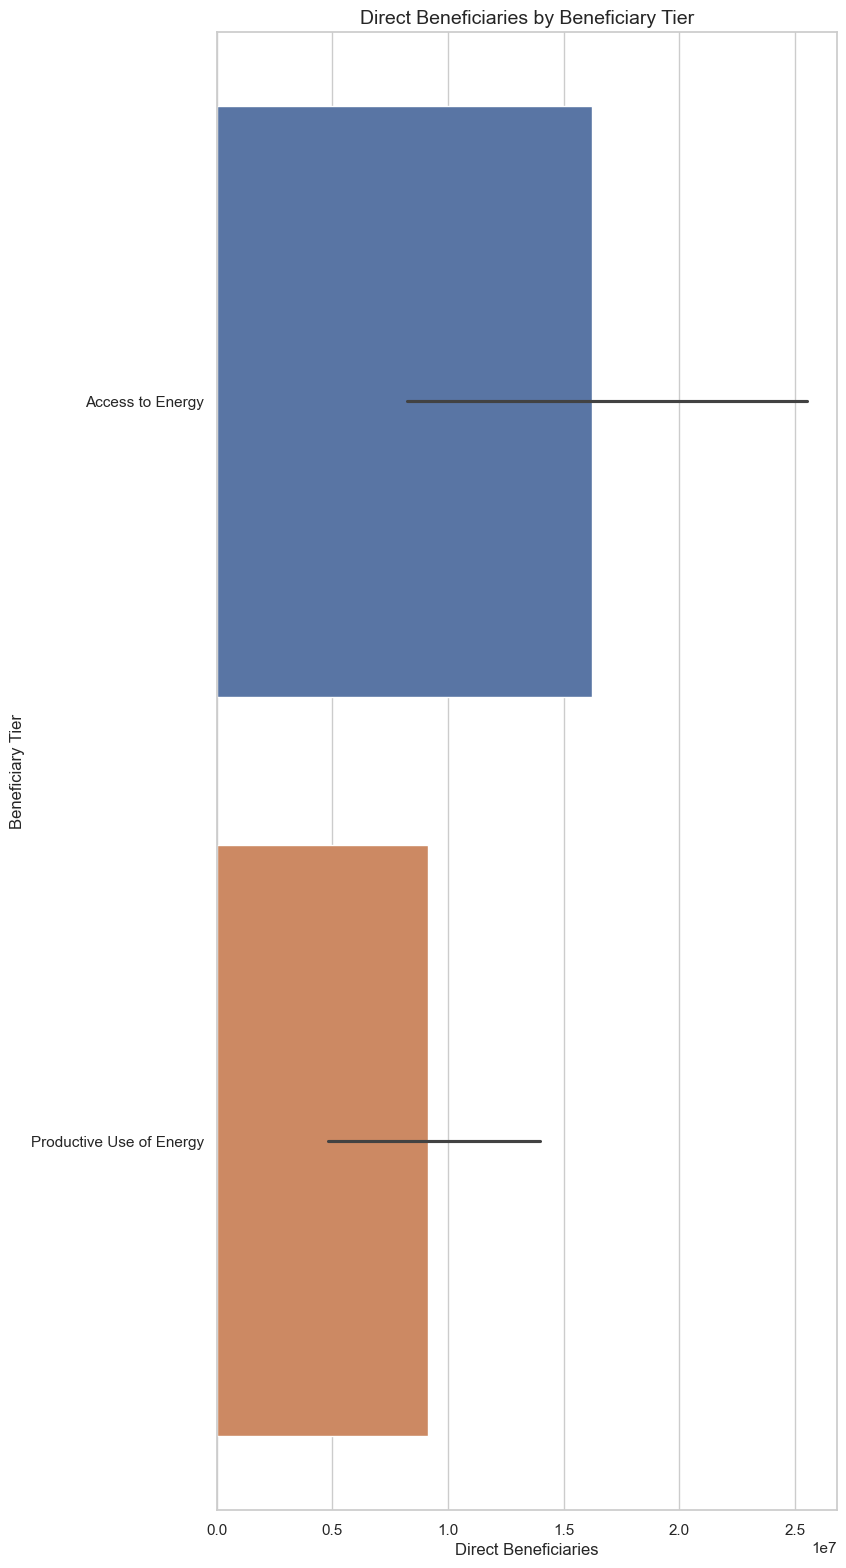

In [39]:
plotCategoryBeneficiaries("Beneficiary Tier","Direct Beneficiaries","Total")

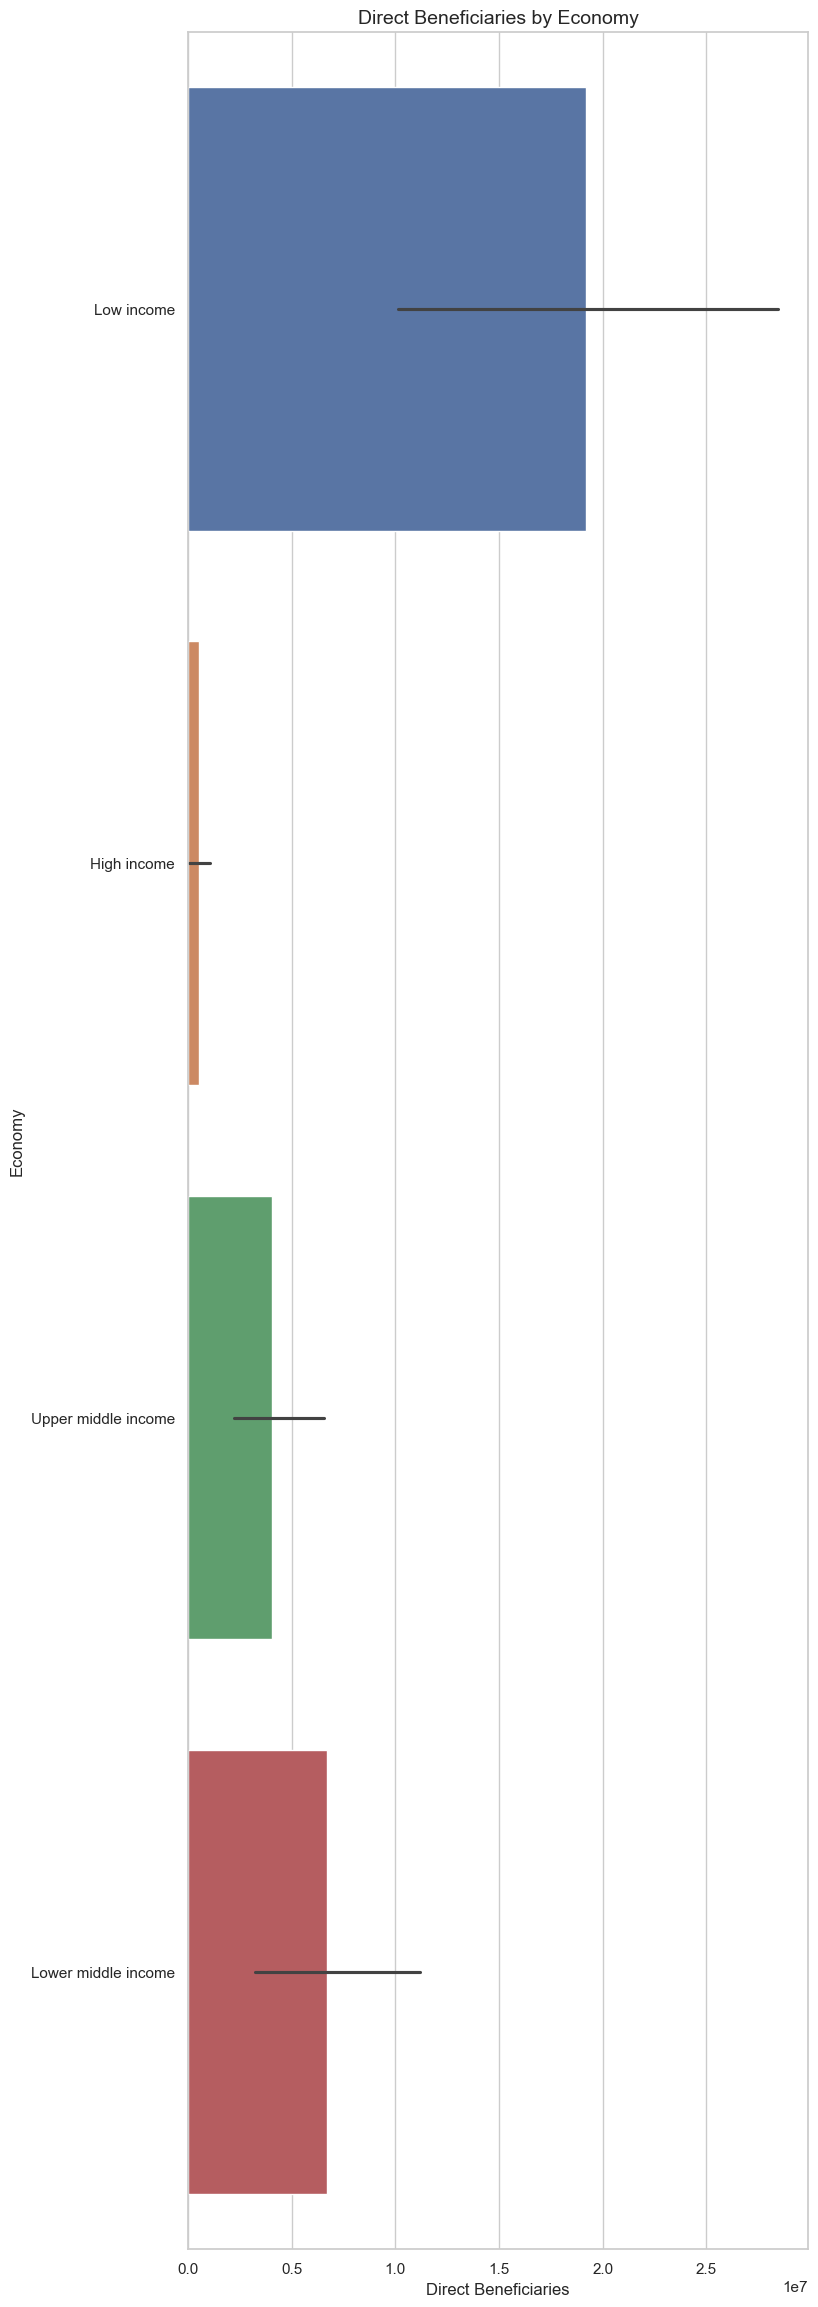

In [40]:
plotCategoryBeneficiaries("Economy","Direct Beneficiaries","Total")

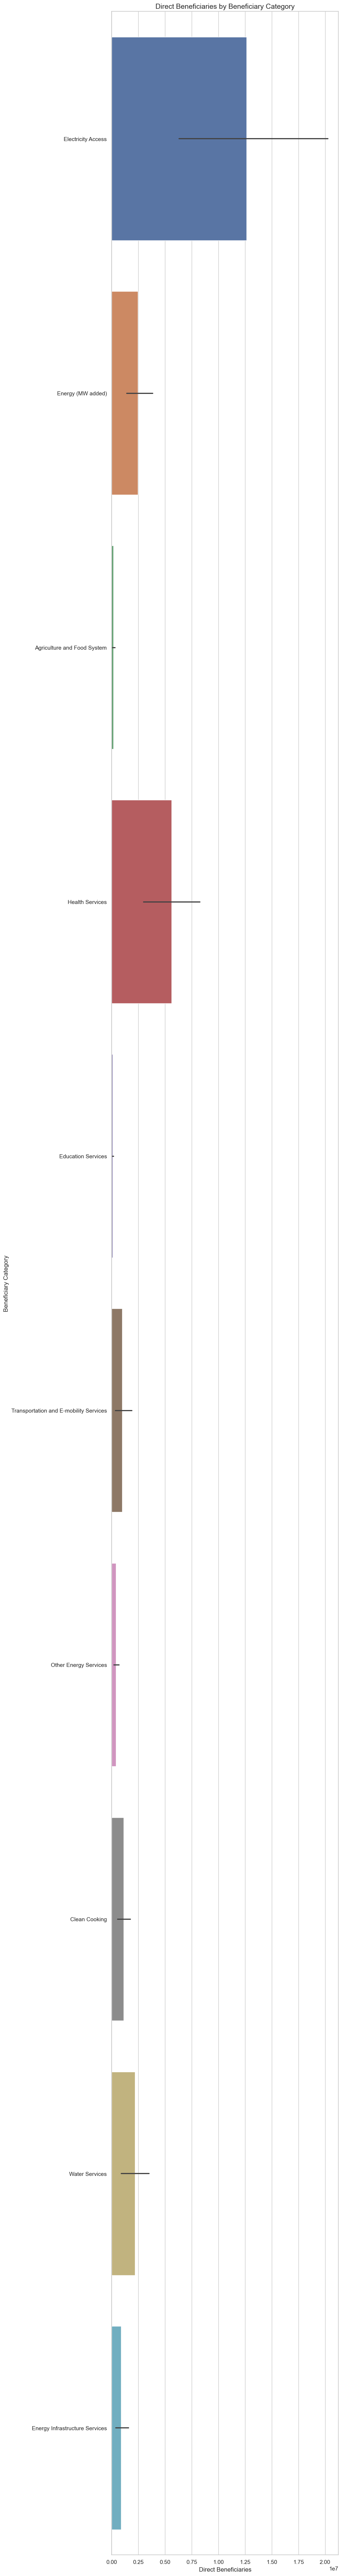

In [41]:
plotCategoryBeneficiaries("Beneficiary Category","Direct Beneficiaries","Total")

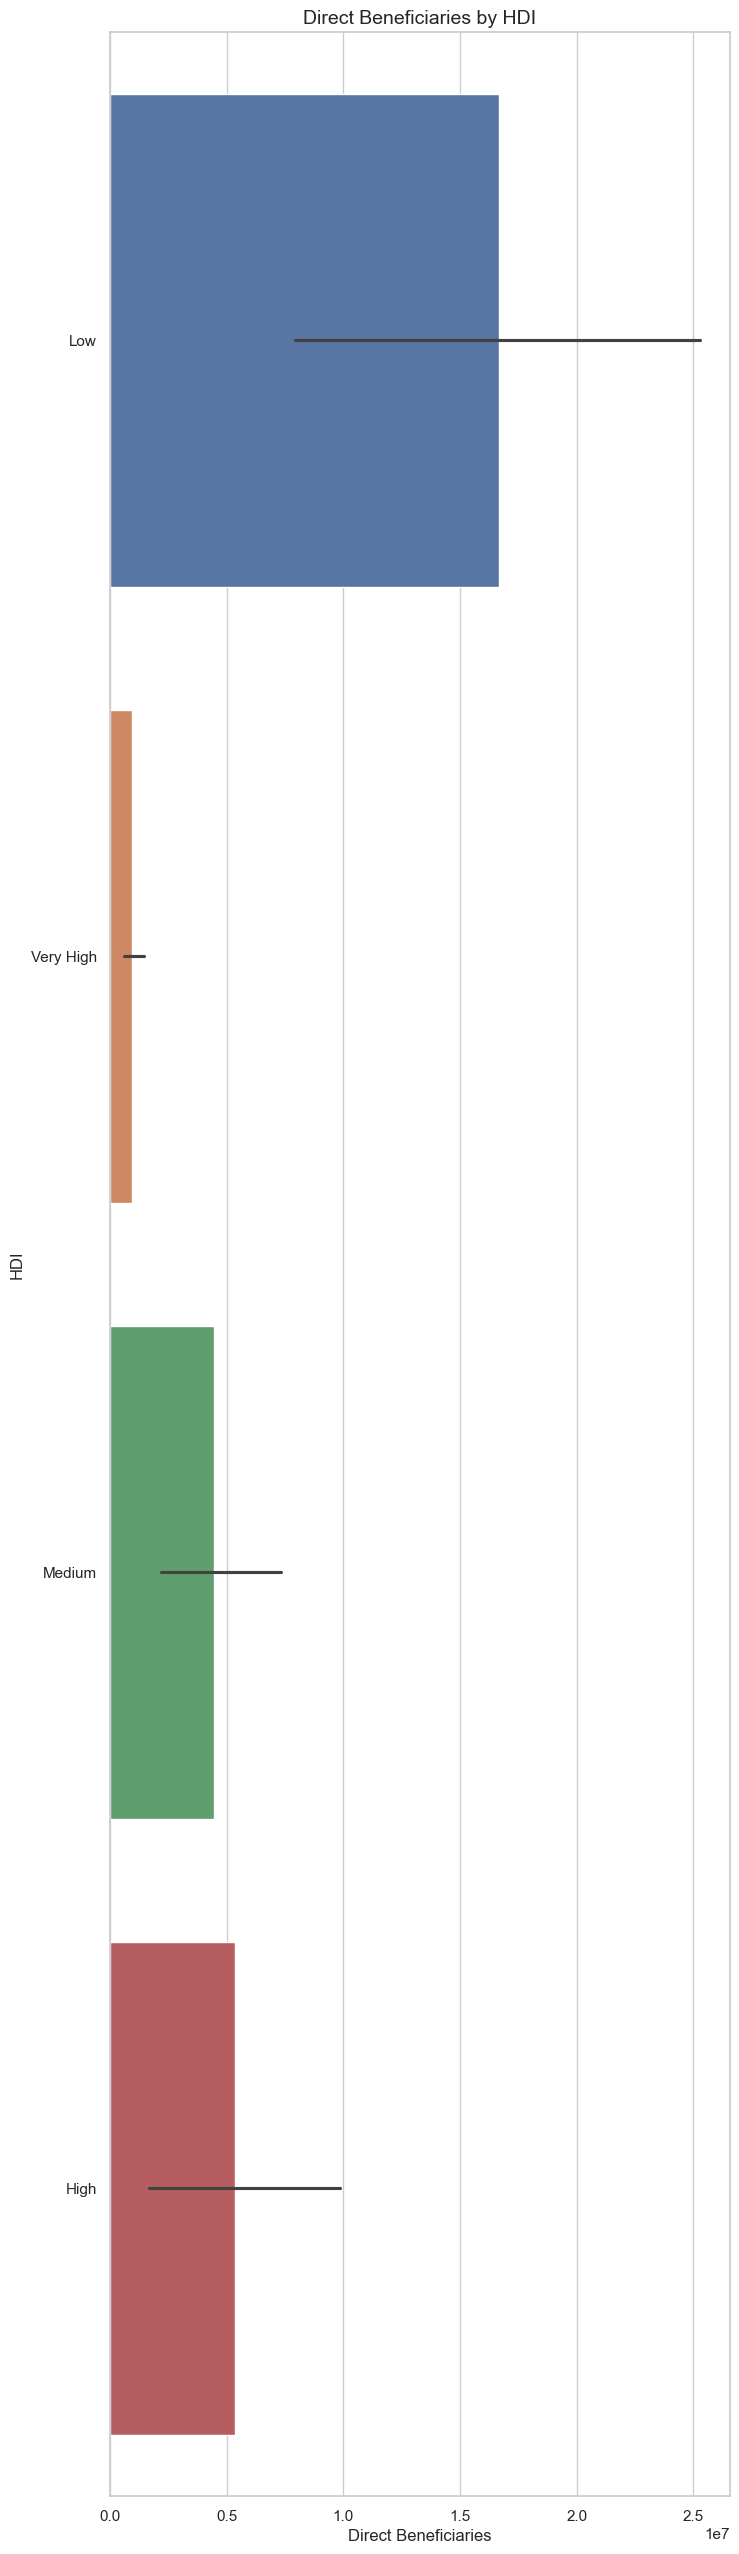

In [42]:
plotCategoryBeneficiaries("HDI","Direct Beneficiaries","Total")

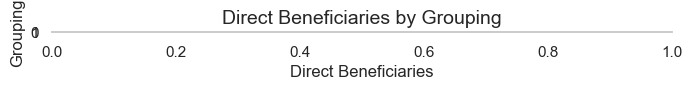

In [43]:
plotCategoryBeneficiaries("Grouping","Direct Beneficiaries","Total")

In [44]:
#df=df[df["Category"].isin(["Electricity Access","Energy (MW added)"])]

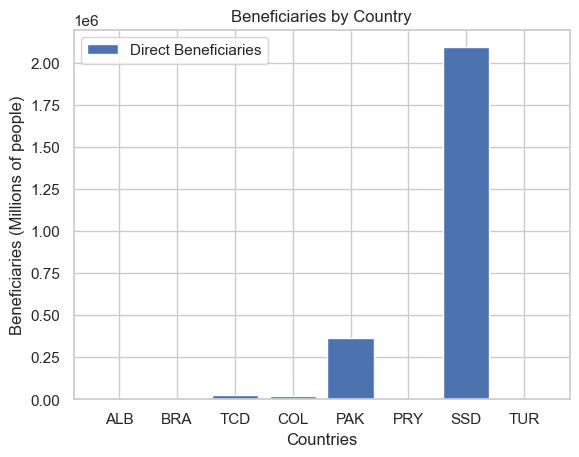

In [45]:
def plotCountryBeneficiaries():
    # Extract data from DataFrame
    
    
    df=updatedCountryMeta[updatedCountryMeta['Country Code'].isin(["BRA", "SSD", "COL", "PAK", "TUR", "TCD", "PRY", "ALB"])]
    
    #df=updatedCountryMeta.nlargest(10, 'Direct Beneficiaries')
       
    x = df['Country Code']
    y1 = df['Direct Beneficiaries']
    #y2 = df['Indirect Beneficiaries']

    # Create the stacked bar chart
    plt.bar(x, y1, label='Direct Beneficiaries')
    #plt.bar(x, y2, bottom=y1, label='Indirect Beneficiaries')

    # Add labels and title
    plt.xlabel('Countries')
    plt.ylabel('Beneficiaries (Millions of people)')
    plt.title("Beneficiaries by Country")
    plt.legend()

    # Display the chart
    plt.show()

plotCountryBeneficiaries()

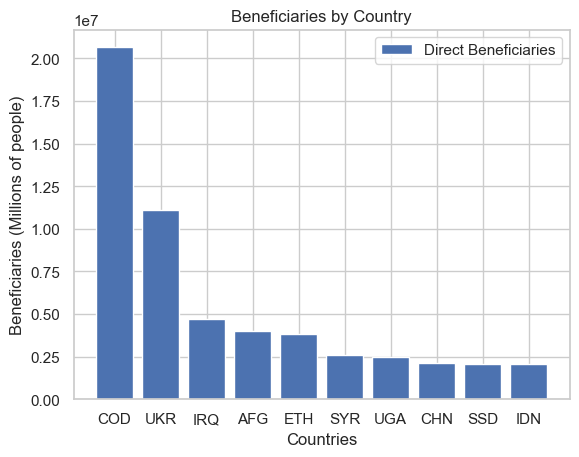

In [46]:
def plotCountryBeneficiaries():
    # Extract data from DataFrame
    
    
    
    df=updatedCountryMeta.nlargest(10, 'Direct Beneficiaries')
       
    x = df['Country Code']
    y1 = df['Direct Beneficiaries']
    #y2 = df['Indirect Beneficiaries']

    # Create the stacked bar chart
    plt.bar(x, y1, label='Direct Beneficiaries')
    #plt.bar(x, y2, bottom=y1, label='Indirect Beneficiaries')

    # Add labels and title
    plt.xlabel('Countries')
    plt.ylabel('Beneficiaries (Millions of people)')
    plt.title("Beneficiaries by Country")
    plt.legend()

    # Display the chart
    plt.show()

plotCountryBeneficiaries()

<h4> Donor analysis </h4>

In [47]:

# calculate donors stats (donors, beneficiaries)
# matplotlib


In [48]:
# projectDonors={}

# for project in projectDf["Project ID"]:
#     donorList=[]
#     for donor in projectDf["Donors"].split(",")
#         donor=donor.replace("'", "").replace("[", "").replace("]", "")

#         split=donor.split("$")
#         if len(split)>1:
#             if testNumeric(split[0]):
#                 val=split[0]
#                 donor=split[1]
#             else if testNumeric(split[1]):
#                 val=split[1]
#                 donor=split[0]
#             else:
#                 donor=split
#         donorList.append(donor)
#     projectDonors[project]=

<h3> run each output through chatgpt to generate description </h3>

In [49]:


system_prompt="You are a consultant studying outputs from UNDP energy-related projects. Generate a short description (<50 words) on the following output based on the information provided. Don't included all the project info, just the specific details of that output. Don't use the name of the country in the result (AKA don't write 'in Colombia'). Start the sentence with the action verb, as in 'Provide access to 500 million' or 'Create 1000 jobs', so don't include at the start 'This project aims to'."

# OpenAI API configuration
load_dotenv()
openai.api_type = "azure"
openai.api_key = os.getenv("api_key_azure")
openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT")
openai.api_version = os.getenv("api_version")
openai_deployment = "sdgi-gpt-35-turbo-16k"

def get_output_description(output_info):
    prompt = f"{system_prompt}\n{output_info}"
   
    response = openai.chat.completions.create(
                    model=openai_deployment,
                    temperature=0,
                    messages=[
                        {"role": "user", "content": prompt},
                    ]
                )
    output_description = response.choices[0].message.content
    return output_description

test_info='{"indicator":"number of beneficiaries","technology":"solar","target":"10000","country":"colombia"}'

#get_output_description(test_info)



In [50]:

def string_to_short_sha256_hash(input_string, num_bytes=4):
    # Compute SHA-256 hash
    hash_obj = hashlib.sha256(input_string.encode())
    # Truncate to the desired number of bytes
    return str(int.from_bytes(hash_obj.digest()[:num_bytes], 'big'))

# Example usage
input_string = "Your 400 character string goes herharacter string goes herharacter string goes herharacter string goes herharacter string goes herharacter string goes herharacter string goes herharacter string goes herharacter string goes here..."
hash_value = string_to_short_sha256_hash(input_string)
print(hash_value)

3845348438


In [51]:


##this code should be used if the AI generated descriptions are needed.
def generateAiDescriptions():
    outputDescriptionFile="../02_Output/02_Outputs/outputDescriptions.json"
    with open(outputDescriptionFile, 'r') as file:
        outputDescriptions = json.load(file)
    for index, row in outputDfComplete.iterrows():
        if index<100000:#lower number for testing
            row_hash=string_to_short_sha256_hash(' '.join(str(value) for value in row))
            print(row_hash)
            if row_hash not in outputDescriptions:
                row_dict=row.to_dict()
                row_dict["Project Description"]=projectDf[projectDf["Project ID"]==row["Project ID"]].iloc[0]["description"]
                description=get_output_description(row_dict)
                print(description)
                outputDescriptions[row_hash]=description
                outputDfComplete.loc[index, 'Description'] = description
            else:
                outputDfComplete.loc[index, 'Description'] = outputDescriptions[row_hash]
                print(index,"already complete.")

    print(outputDescriptions)

    with open(outputDescriptionFile, 'w') as file:
        json.dump(outputDescriptions, file) 
    
#generateAiDescriptions()
    

    

In [53]:
##this code uses the manual output descriptions file

outputDescriptionsManual = pd.read_csv("../01_Input/07_Outputs/Output Descriptions Manual.csv")

outputDfComplete = outputDfComplete.merge(outputDescriptionsManual[['Output ID', 'Description']], on='Output ID', how='left')

print(outputDfComplete)

     Project ID                                              Title  \
0      117913.0      Résilience des communautés et des écosystèmes   
1      117913.0      Résilience des communautés et des écosystèmes   
2      117913.0      Résilience des communautés et des écosystèmes   
3      134793.0  Accès aux énergies renouvelables en milieu rur...   
4      134793.0  Accès aux énergies renouvelables en milieu rur...   
...         ...                                                ...   
1182     130610                      Multilateral Support to COP27   
1183   132255.0  Projet d’Electrification  Rurale en Zones Isol...   
1184   132255.0  Projet d’Electrification  Rurale en Zones Isol...   
1185   132255.0  Projet d’Electrification  Rurale en Zones Isol...   
1186   131201.0                                         Paix Verte   

                                        Link       Budget  \
0     http://open.undp.org/projects/00117913    3459600.0   
1     http://open.undp.org/projects/0

<h4> Export xlsx with each df as a separate sheet </h4>

In [54]:
###Export full xlsx with all dfs as tabs
# Create ExcelWriter object
writer = pd.ExcelWriter('../02_Output/00_Final Results/Moonshot Tracker Results - Auto.xlsx', engine='xlsxwriter')

# Write DataFrames to separate sheets
summaryDf.to_excel(writer, sheet_name='Summary', index=False)
outputDfComplete.to_excel(writer, sheet_name='Outputs', index=False)
projectDf.to_excel(writer, sheet_name='Projects', index=False)
updatedCountryMeta.to_excel(writer, sheet_name='Countries', index=False)
#donorDf.to_excel(writer, sheet_name='Donors', index=False)

# Save the Excel file
writer.close()

In [55]:
valuesDict={"Education Services":"Education","Agriculture and Food System":"Agriculture","Water Services":"Water","Infrastructure Services":"Infrastructure","Health Services":"Health","Transportation and E-mobility Services":"Transport"}



<h3> convert results to json format for dashboard </h3>

In [56]:
projectsJson=[]
projectDf=projectDf.fillna(np.nan).replace([np.nan], [None])
outputDfComplete=outputDfComplete.fillna(np.nan).replace([np.nan], [None])
#outputDfComplete.dropna(subset=["Beneficiary Category"], inplace=True)
outputDfComplete["Beneficiary Category"]=outputDfComplete["Beneficiary Category"].fillna("Missing")

for index,projectRow in projectDf.iterrows():
    
    newProject={}
    newProject["id"]=str(projectRow["Project ID"]).replace(".0","")
    newProject["title"]=projectRow["Project Title"]
    
    linkResult=urlparse(projectRow["Link"])

    if all([linkResult.scheme, linkResult.netloc]):
        newProject["link"]=projectRow["Link"]
    else:
        newProject["link"]=None

    newProject["budget"]=projectRow["Budget"]
    newProject["countryCode"]=projectRow["Country Code"]
    newProject["countryName"]=projectRow["Country"]
    try:
        if projectRow["GHG Emissions Reduction"]>0:
            newProject["ghgEmissions"]= projectRow["GHG Emissions Reduction"]
        else:
            newProject["ghgEmissions"]=None
    except:
        newProject["ghgEmissions"]=None

        
    newProject["verticalFunded"]=(projectRow["VF or Non-VF"]=="VF")
    if projectRow["Project Description"]:
        newProject["description"]=projectRow["Project Description"]
    else:
        newProject["description"]=str(projectRow["description"])
    if len(newProject["description"])<10:
        newProject["description"]="add project description"
    newProject["genderMarker"]=projectRow["Gender Marker"]
    try:
        newProject["donors"]=projectRow["Donors"].replace("[","").replace("]","").replace("'","").strip().split(",")
    except:
        newProject["donors"]=None

    if "GEN" not in newProject["genderMarker"]:
        newProject["genderMarker"]=None
    
   
    outputDfProject=outputDfComplete[outputDfComplete["Project ID"]==projectRow["Project ID"]]
    outputRow=outputDfProject.iloc[0]
    
    newProject["region"]=outputRow["Region"]
    try:
        newProject["thematics"]=outputRow["Tag"].split(",") 
    except:
        newProject["thematics"]=[]
    newProject["flagship"]=outputRow["Flagship"]
    newProject["hdiTier"]=outputRow["HDI"]    
    newProject["incomeGroup"]=outputRow["Economy"]
    newProject["specialGroupings"]=[outputRow[col] for col in ['SIDS', 'LLDC', 'LDC'] if not pd.isna(outputRow[col])]
 
    outputsJson=[]

    for index, outputRow in outputDfProject.iterrows():
        print(outputRow["Beneficiary Category"])
        newOutput={}
        newOutput["outputCategory"]=outputRow["Output Category"]
        
        if outputRow["Beneficiary Category"] in valuesDict:
            newOutput["beneficiaryCategory"]=valuesDict[outputRow["Beneficiary Category"]]
        else:
            newOutput["beneficiaryCategory"]=outputRow["Beneficiary Category"]
        if outputRow["Beneficiary Category Pre"]=="Energy (MW added)":
            try:
                newOutput["mwAdded"]=outputRow["Target"]-outputRow["Baseline"]
            except:
                if outputRow["Target"]:
                    newOutput["mwAdded"]=outputRow["Target"]
                else:
                    newOutput["mwAdded"]=0
        else:
            newOutput["mwAdded"]=0
         
        if outputRow["Beneficiary Category"]=="Efficiency":
            newOutput["energySaved"]=outputRow["Target"]
        else:
            newOutput["energySaved"]=0
            
        if outputRow["Beneficiary Category Pre"]=="Policy or Regulatory Framework":
            newOutput["policies"]=1
        else:
            newOutput["policies"]=0
            
        if outputRow["Beneficiary Category"]=="Finance":
            newOutput["finance"]=0
        else:
            newOutput["finance"]=0        


        newOutput["directBeneficiaries"]=outputRow["Direct Beneficiaries"]
        
        
        newOutput["percentFemale"]=outputRow["Gender (% female)"]
#         if newOutput["percentFemale"]==False:
#             newOutput["percentFemale"]=None
        if type(newOutput["percentFemale"])==str:
            if "%" in newOutput["percentFemale"]:
                try:
                    newOutput["percentFemale"]=float(newOutput["percentFemale"].replace('%', 'e-2'))
                except:
                    newOutput["percentFemale"]=None
        try:
            if (newOutput["percentFemale"])<1:
                newOutput["percentFemale"]=newOutput["percentFemale"]*100
        except:
            newOutput["percentFemale"]=None
        try:
            newOutput["description"]=outputRow["Description"]
        except:
            newOutput["description"]=""
        
        ## confirm numeric values are numeric
        
        for key in ["energySaved","mwAdded","directBeneficiaries","percentFemale"]:
            try:
                newOutput[key] = float(newOutput[key])
            except:    
                if newOutput[key]:
                    print(newOutput[key])
                    newOutput[key]=None
                    print(projectRow["Country"],newProject["id"],key,"nonnumeric")

        newOutput["id"]= (newProject["countryCode"]+"-"+newProject["id"] +"-"+ newOutput["beneficiaryCategory"] + "-"+str(len(outputsJson))).replace(" ","") 

        outputsJson.append(newOutput)
        
    newProject["outputs"]=outputsJson

    projectsJson.append(newProject)

print(projectsJson)
with open('../02_Output/06_Dashboard/moonshotData.json', 'w') as jsonfile:
    json.dump(projectsJson, jsonfile)

Clean Electricity
Other
Other
Clean Electricity
Other
Other
Clean Electricity
Policy - Overall
Solar
Policy - Overall
Agriculture and Food System
Other
Solar
Health Services
Other
Solar
Some Sources
Clean Electricity
Clean Electricity
Education Services
Health Services
Policy - Renewable Energy
Other
Clean Electricity
Other
Other
Efficiency
Clean Electricity
Other
Policy - Renewable Energy
Wind
Policy - Renewable Energy
Policy - Renewable Energy
Other
Other
Other
Other
Clean Electricity
Other
Other
Other
Other
Some Sources
132 target
Samoa 5669 mwAdded nonnumeric
Clean Electricity
Other
Policy - Other
Policy - Other
Transportation and E-mobility Services
Other
Other
Policy - Renewable Energy
Other Energy Services
Transition Missing
Policy - Renewable Energy
Policy - Renewable Energy
Other Energy Services
Efficiency
Other
Other
Transportation and E-mobility Services
Health Services
Education Services
Clean Cooking
Water Services
Other
Transition Missing
Transportation and E-mobility Ser

In [57]:
if not isinstance("4", numbers.Number):
    print("why")

why


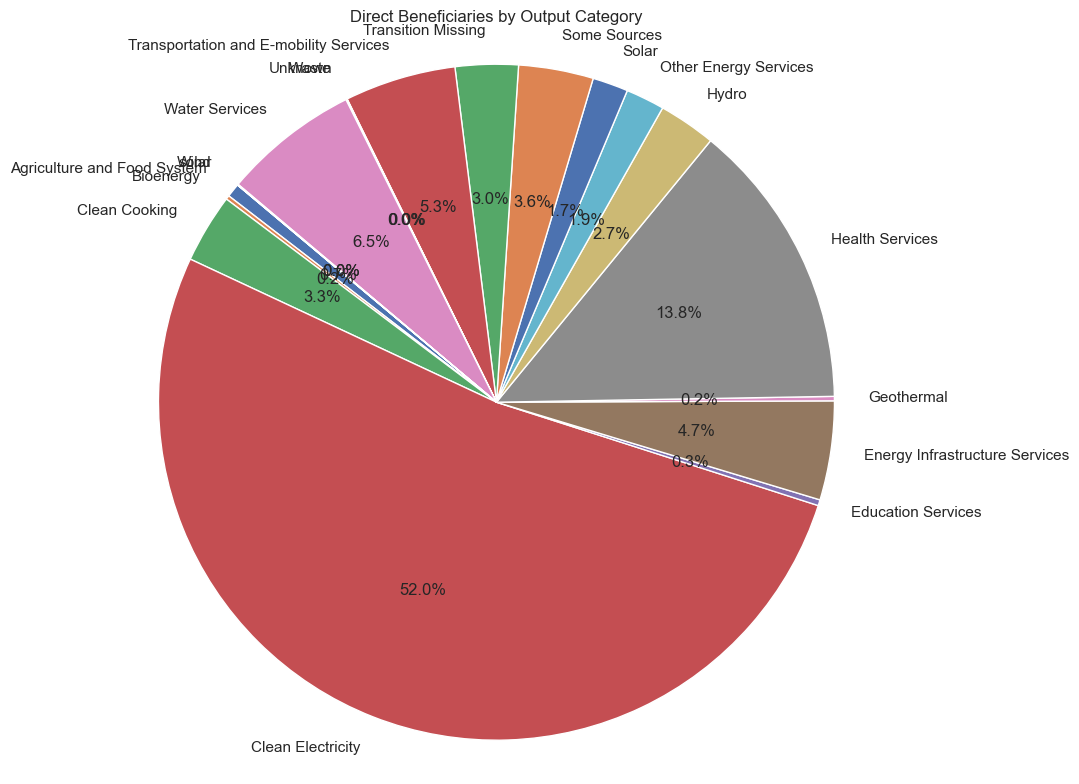

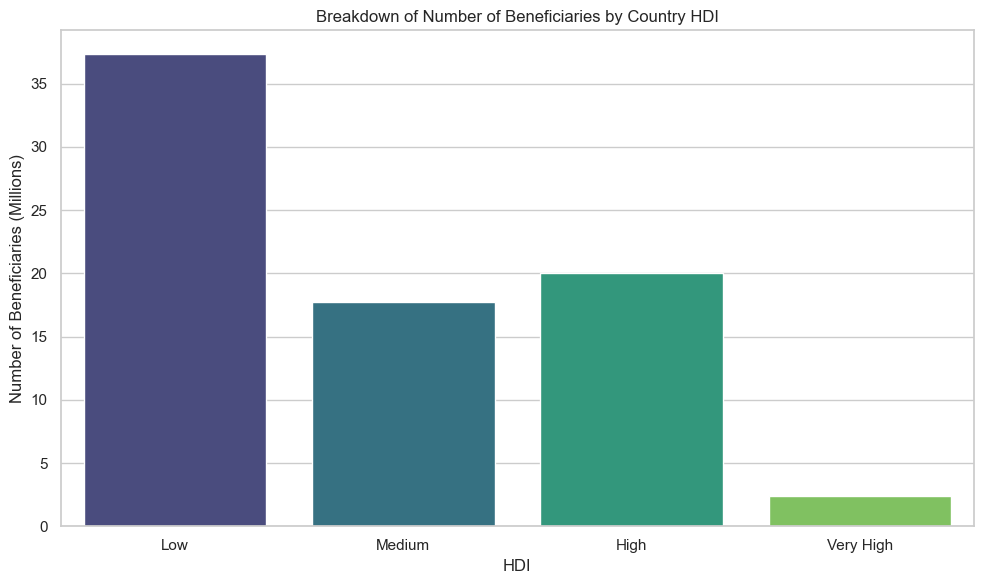

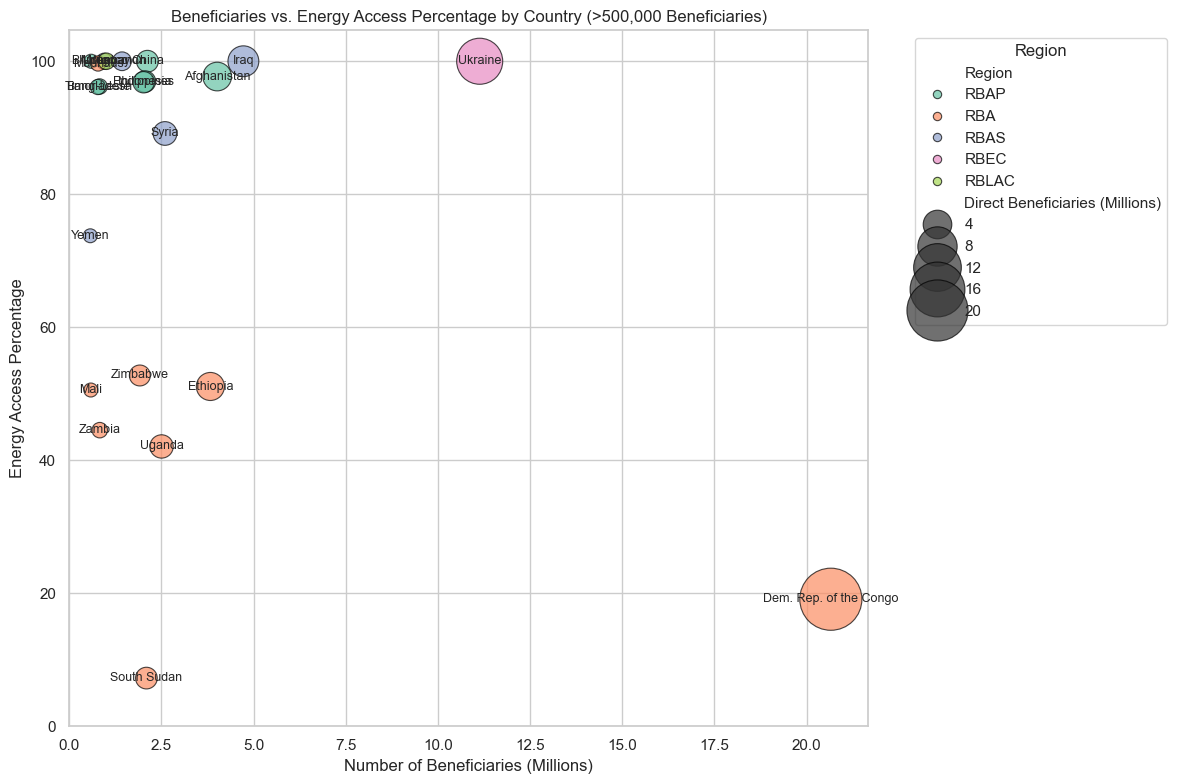

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use the provided DataFrame
df = outputDfComplete

# ---------------------------------------------
# 1. Pie Chart of Direct Beneficiaries by Output Category
# ---------------------------------------------

# Ensure 'Direct Beneficiaries' is numeric
df['Direct Beneficiaries'] = pd.to_numeric(df['Direct Beneficiaries'], errors='coerce')

# Group by 'Output Category' and sum 'Direct Beneficiaries'
beneficiaries_by_output = df.groupby('Beneficiary Category')['Direct Beneficiaries'].sum()

# Remove any categories with zero or NaN beneficiaries
beneficiaries_by_output = beneficiaries_by_output[beneficiaries_by_output > 0]

# Plot pie chart
plt.figure(figsize=(10, 8))
beneficiaries_by_output.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.ylabel('')
plt.title('Direct Beneficiaries by Output Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 2. Breakdown of Number of Beneficiaries by Country HDI
#    (Y-axis in Millions of Beneficiaries)
# ---------------------------------------------

# Group by 'HDI' and sum 'Direct Beneficiaries'
beneficiaries_by_hdi = df.groupby('HDI')['Direct Beneficiaries'].sum().reset_index()

# Convert 'Direct Beneficiaries' to millions
beneficiaries_by_hdi['Direct Beneficiaries (Millions)'] = beneficiaries_by_hdi['Direct Beneficiaries'] / 1e6

# Sort HDI categories
hdi_order = ['Low', 'Medium', 'High', 'Very High']
beneficiaries_by_hdi['HDI'] = pd.Categorical(beneficiaries_by_hdi['HDI'], categories=hdi_order, ordered=True)
beneficiaries_by_hdi = beneficiaries_by_hdi.sort_values('HDI')

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=beneficiaries_by_hdi, x='HDI', y='Direct Beneficiaries (Millions)', palette='viridis')
plt.ylabel('Number of Beneficiaries (Millions)')
plt.title('Breakdown of Number of Beneficiaries by Country HDI')
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 3. Bubble Chart: Beneficiaries vs. Energy Access Percentage by Country
#    (Adjusted as per your instructions)
# ---------------------------------------------

# Read energy access data without skipping rows
energy_access = pd.read_csv(
    "../01_Input/02_Energy Data/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_5358776/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_5358776.csv"
)

# Get the list of year columns (assuming years are columns like '1960', '1961', etc.)
year_cols = [col for col in energy_access.columns if col.isdigit()]

# Function to get the latest available energy access percentage for each country
def get_latest_value(row):
    for year in reversed(year_cols):
        if not pd.isnull(row[year]):
            return row[year]
    return None

# Apply the function to create a new column
energy_access['Latest Energy Access Percentage'] = energy_access.apply(get_latest_value, axis=1)

# Keep necessary columns
energy_access = energy_access[['Country Code', 'Latest Energy Access Percentage']]

# Ensure 'Latest Energy Access Percentage' is numeric
energy_access['Latest Energy Access Percentage'] = pd.to_numeric(
    energy_access['Latest Energy Access Percentage'], errors='coerce'
)

# Group the df DataFrame
df_country_beneficiaries = df.groupby(['Country Code', 'Country Name', 'Region'])['Direct Beneficiaries'].sum().reset_index()

# Merge dataframes on 'Country Code'
df_beneficiaries_energy = pd.merge(df_country_beneficiaries, energy_access, on='Country Code', how='left')

# Remove rows with missing energy access data
df_beneficiaries_energy.dropna(subset=['Latest Energy Access Percentage'], inplace=True)

# Only include countries with >500,000 beneficiaries
df_beneficiaries_energy = df_beneficiaries_energy[df_beneficiaries_energy['Direct Beneficiaries'] > 500000]

# Exclude Venezuela
df_beneficiaries_energy = df_beneficiaries_energy[df_beneficiaries_energy['Country Code'] != 'VEN']

# Convert 'Direct Beneficiaries' to millions for x-axis
df_beneficiaries_energy['Direct Beneficiaries (Millions)'] = df_beneficiaries_energy['Direct Beneficiaries'] / 1e6

# Plot bubble chart with swapped axes and adjusted x-axis
plt.figure(figsize=(12, 8))

# Improve aesthetics by setting style
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=df_beneficiaries_energy,
    x='Direct Beneficiaries (Millions)',
    y='Latest Energy Access Percentage',
    size='Direct Beneficiaries (Millions)',
    sizes=(100, 2000),
    hue='Region',
    alpha=0.7,
    edgecolor='black',
    palette='Set2',
    legend='brief'
)

# Annotate each bubble with the country name
for i, row in df_beneficiaries_energy.iterrows():
    plt.text(
        row['Direct Beneficiaries (Millions)'],
        row['Latest Energy Access Percentage'],
        row['Country Name'],
        fontsize=9,
        ha='center',
        va='center'
    )

# Set origin at (0, 0)
plt.xlim(0, )
plt.ylim(0, )

# Add labels and title
plt.xlabel('Number of Beneficiaries (Millions)')
plt.ylabel('Energy Access Percentage')
plt.title('Beneficiaries vs. Energy Access Percentage by Country (>500,000 Beneficiaries)')

# Move legend outside the plot
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
